In [1]:
import csv
import numpy as np
import scipy
import os
import sys
import cvxpy as cp

## Coronavirus Data Exploration

We're doing a bit of open ended exploration of the coronavirus data provided by the New York Times. (https://github.com/nytimes/covid-19-data)

1. Under an initial simplified assumption, we can see how the coronavirus infections will exponentially escalate in the near future

2. Under a more complicated assumption, we can simulate how infections will spread and de-escalate over time. We can use this to show at a high level how government policies on social distancing can potentially affect capacity planning of our medical facilities. (Flatten the Curve: https://www.livescience.com/coronavirus-flatten-the-curve.html)

In [2]:
cases_dict={}
deaths_dict={}
flips_dict={}

In [3]:
with open('us-states.csv','r') as fl:
    country_reader=csv.reader(fl)
    for row in country_reader:
        if row[1] not in cases_dict:
            cases_dict[row[1]]=[]
            deaths_dict[row[1]]=[]
            flips_dict[row[1]]=[]
        cases_dict[row[1]].append((row[0],row[3]))
        deaths_dict[row[1]].append((row[0],row[4]))
        flips_dict[row[1]].append((row[0],row[2]))

In [4]:
import matplotlib.pyplot as plt

In [5]:
import datetime
days_ca=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
cases_ca=[int(x[1]) for x in cases_dict['California']]
days_ny=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
cases_ny=[int(x[1]) for x in cases_dict['New York']]
days_wa=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Washington']]
cases_wa=[int(x[1]) for x in cases_dict['Washington']]
days_la=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Louisiana']]
cases_la=[int(x[1]) for x in cases_dict['Louisiana']]
days_nj=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New Jersey']]
cases_nj=[int(x[1]) for x in cases_dict['New Jersey']]

We're just looking at the number of infections over time for the different states here. We see New York has been growing much faster than the rest of the population centers. (It's probably due to the fact that NYC is a major travel hub among internation travelers, and many people use the metro system extensively)

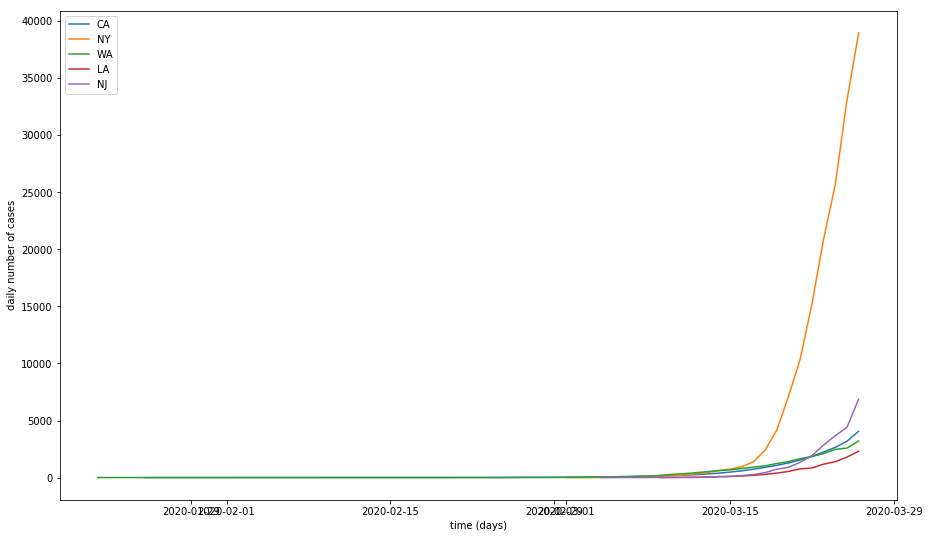

In [6]:
plt.figure(figsize=(15,9))
plt.plot(days_ca,cases_ca,label='CA')
plt.plot(days_ny,cases_ny,label='NY')
plt.plot(days_wa,cases_wa,label='WA')
plt.plot(days_la,cases_la,label='LA')
plt.plot(days_nj,cases_nj,label='NJ')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [7]:
start_date_ca=cases_dict['California'][0][0]
start_date_ny=cases_dict['New York'][0][0]

In [8]:
def date_to_days(base_str_date,input_str_date):
    return (datetime.datetime.strptime(input_str_date,"%Y-%m-%d").date()-datetime.datetime.strptime(base_str_date,"%Y-%m-%d").date()).days

In [9]:
input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California']]

In [10]:
input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York']]

In [11]:
ca_data_for_model=zip(input_data_ca_days,cases_ca)

### Initial Assumptions

We first assume the infection spreads exponentially. (Assume a world where each person can infect x people. Then those x people each can infect x people...)

In [12]:
from IPython.display import Math
Math(r'y = Ae^{bt}')

<IPython.core.display.Math object>

We will try to fit the exponential curve to our data. By converting our data to a log scale our problem becomes a classic linear least squares regression.

Let's figure out the model for California

In [13]:
A_ca = cp.Variable(pos=True)
b_ca = cp.Variable()

y_ca = np.log(cases_ca[30:])
x_ca = input_data_ca_days[30:]
x_ca = [i - 30 for i in x_ca]
#cost = cp.log_sum_exp( y - A*cp.exp(b*x))
cost_ca = cp.sum_squares( y_ca - A_ca - b_ca*x_ca )
prob_ca = cp.Problem(cp.Minimize(cost_ca))
prob_ca.solve()

#x = cp.Variable(pos=True)
print("\nThe optimal value is", prob_ca.value)
print("The optimal log(A) is")
print(A_ca.value)
print("The optimal b value is")
print(b_ca.value)



The optimal value is 0.4816122110307081
The optimal log(A) is
2.4171653312438126
The optimal b value is
0.18799598694364683


In [14]:
print("cases increase by a factor of "+str(A_ca.value)+" every "+str(1/b_ca.value)+" days")

cases increase by a factor of 2.4171653312438126 every 5.319262481383484 days


We plot the log scale fit

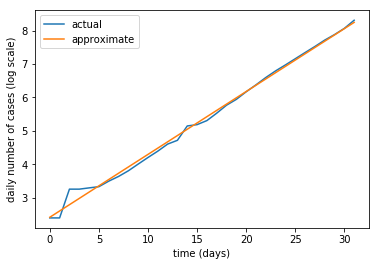

In [15]:
plt.plot(x_ca,y_ca, label='actual')
plt.plot(x_ca, [ A_ca.value + b_ca.value * i for i in x_ca] , label='approximate')
plt.legend()
plt.ylabel('daily number of cases (log scale)')
plt.xlabel('time (days)')
plt.show()

In [16]:
#very good fit

In [17]:
mn=np.mean(y_ca)
res_reg=sum([(mn - A_ca.value - b_ca.value * i)**2 for i in x_ca])
#print(res)
res_tot=sum([(mn - g)**2 for g in y_ca])
print(res_reg/res_tot)

0.9950295928712736


We see the corresponding exponential model is a pretty good fit

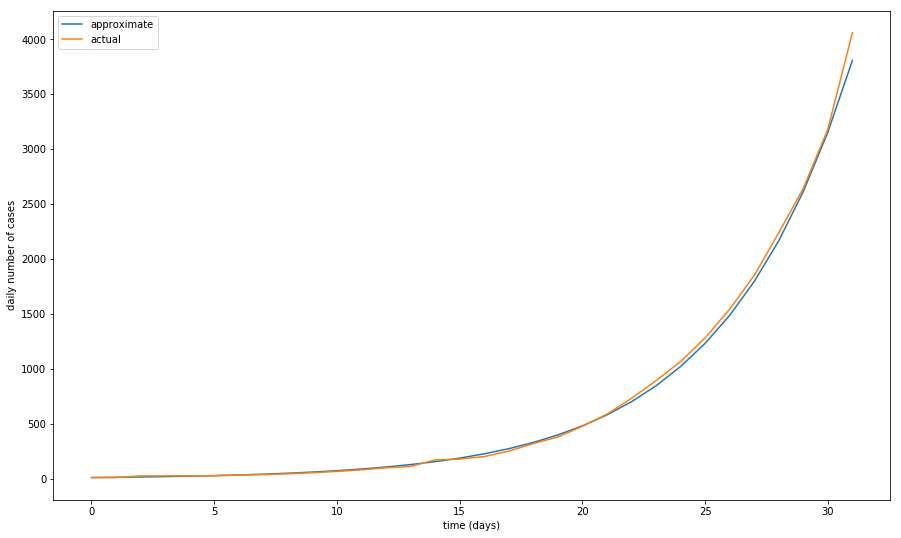

In [18]:
plt.figure(figsize=(15,9))
plt.plot(x_ca, [ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca],label='approximate')
plt.plot(x_ca,np.exp(y_ca),label='actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [19]:

#we don't model on first 30 days because we assume the data is too sparse to draw any conclusions.
#we also get a better fit on the last 60 days.

Let's figure out the model for New York

In [20]:
A_ny = cp.Variable(pos=True)
b_ny = cp.Variable()

cases_ny_sub = [x-0 for x in cases_ny]#cases_ny[1] for x in cases_ny]
y_ny = np.log(cases_ny_sub[20:])

x_ny = input_data_ny_days[20:]
x_ny = [i - 20 for i in x_ny]
#cost = cp.log_sum_exp( y - A*cp.exp(b*x))
cost_ny = cp.sum_squares( y_ny - A_ny - b_ny*x_ny )
prob_ny = cp.Problem(cp.Minimize(cost_ny))
prob_ny.solve()

#x = cp.Variable(pos=True)
print("\nThe optimal value is", prob_ny.value)
print("The optimal log(A) is")
print(A_ny.value)
print("The optimal b value is")
print(b_ny.value)


The optimal value is 0.02358479643158165
The optimal log(A) is
9.336247155055942
The optimal b value is
0.2620811359377255


In [21]:
print("cases increase by a factor of "+str(A_ny.value)+" every "+str(1/b_ny.value)+" days")

cases increase by a factor of 9.336247155055942 every 3.815612277556731 days


Again, we plot the log scale fit here

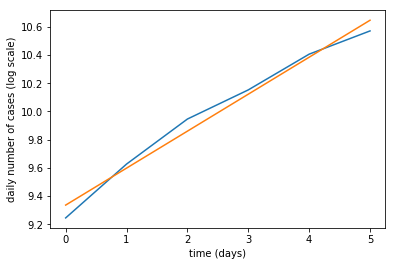

In [22]:
plt.plot(x_ny,y_ny)
plt.plot(x_ny, [ A_ny.value + b_ny.value * i for i in x_ny] )
plt.ylabel('daily number of cases (log scale)')
plt.xlabel('time (days)')
plt.show()

In [23]:
# good fit
mn=np.mean(y_ny)
res_reg=sum([(mn - A_ny.value - b_ny.value * i)**2 for i in x_ny])
#print(res)
res_tot=sum([(mn - g)**2 for g in y_ny])
print(res_reg/res_tot)

0.9807565134978256


The corresponding exponential model here shows us that based on the recent few days, things will escalate quickly

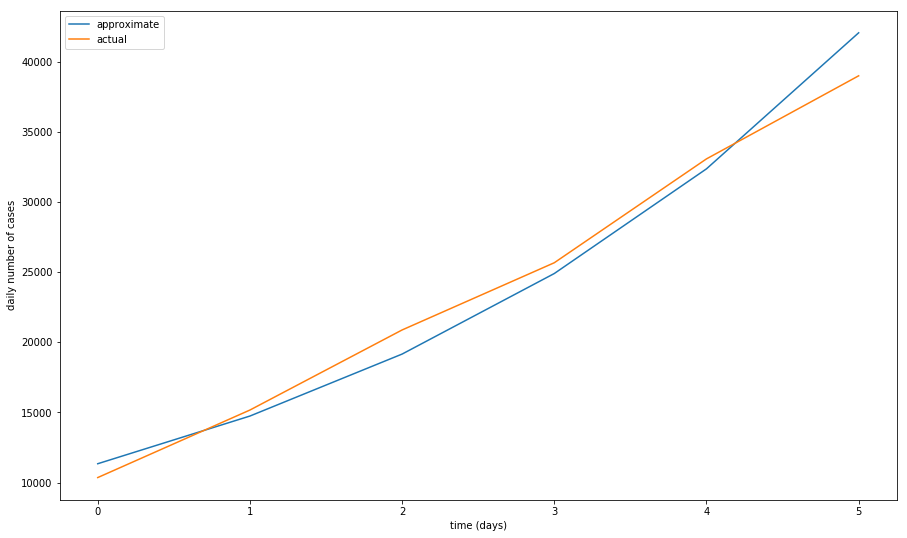

In [24]:
plt.figure(figsize=(15,9))
plt.plot(x_ny, [ np.exp(A_ny.value) * np.exp(i * b_ny.value) for i in x_ny],label='approximate')
plt.plot(x_ny,np.exp(y_ny),label='actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [25]:
#20 days ago ny was following a different model

We see that in approximately 2 weeks California will reach New York levels of today, but its rate of infection will not surpass New York

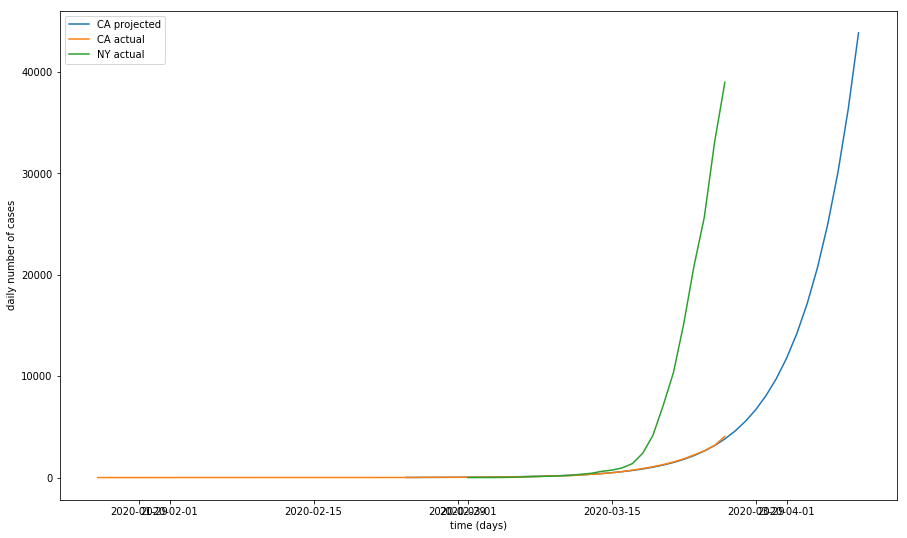

In [26]:
plt.figure(figsize=(15,9))

days_ca_sub=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
for z in range(13):
    days_ca_sub.append(days_ca_sub[-1]+datetime.timedelta(1))
input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California'][30:]]
for z in range(13):
    input_data_ca_days.append(input_data_ca_days[-1]+1)
x_ca = input_data_ca_days
x_ca = [i - 30 for i in x_ca]


plt.plot(days_ca_sub[30:], [ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca],label='CA projected')
plt.plot(days_ca,cases_ca,label='CA actual')
plt.plot(days_ny,cases_ny,label='NY actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In approximately one week New York will escalate by 5x

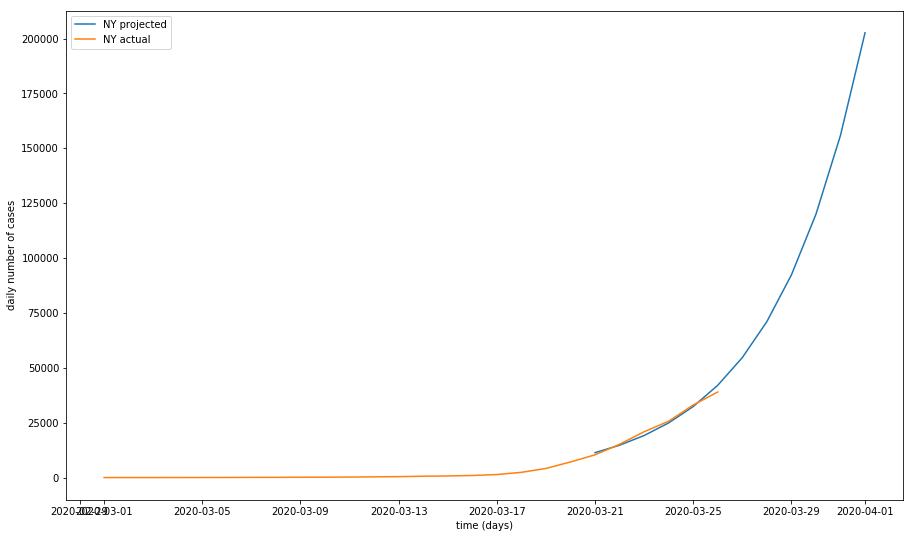

In [27]:
plt.figure(figsize=(15,9))

days_ny_sub=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
for z in range(6):
    days_ny_sub.append(days_ny_sub[-1]+datetime.timedelta(1))
input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York'][20:]]
for z in range(6):
    input_data_ny_days.append(input_data_ny_days[-1]+1)
x_ny = input_data_ny_days
x_ny = [i - 20 for i in x_ny]

plt.plot(days_ny_sub[20:], [ np.exp(A_ny.value) * np.exp(i * b_ny.value) for i in x_ny],label='NY projected')
plt.plot(days_ny,cases_ny,label='NY actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

### Advanced Assumptions

We now assume the infection spreads exponentially, but is dampened by how much population is left to infect over time

In [28]:
from IPython.display import Math
Math(r'\frac{\partial y}{\partial t} = cy\frac{\int_{t}^{T}y(t)dt - \int_{0}^{t}y(t)dt}{\int_{0}^{T}y(t)dt}')

<IPython.core.display.Math object>

We can play around with different parameters:

The total population amount we expect to get infected over time.

The infection rate c

In [29]:
y_ode = []
y_ode.append(np.exp(y_ca[0]))
pop=2550000
c=0.2
y_ode2 = []
y_ode2.append(np.exp(y_ca[0]))
pop2=2550000
c2=0.3

In [30]:
for i in range(100):
    #numerical integration: trapezoidal rule
    if len(y_ode)==1:
        sum_ode=0.5*y_ode[-1]
        sum_ode2=0.5*y_ode2[-1]
    elif len(y_ode)==2:
        sum_ode=0.5*(y_ode[0]+y_ode[-1])
        sum_ode2=0.5*(y_ode2[0]+y_ode2[-1])
    else:
        sum_ode=0.5*(y_ode[0]+y_ode[-1])+sum(y_ode[1:-1])
        sum_ode2=0.5*(y_ode2[0]+y_ode2[-1])+sum(y_ode2[1:-1])
    y_temp = c*y_ode[-1]*(pop-sum_ode-sum_ode)/pop+y_ode[-1]
    y_ode.append(y_temp)
    y_temp2 = c2*y_ode2[-1]*(pop2-sum_ode2-sum_ode2)/pop2+y_ode2[-1]
    y_ode2.append(y_temp2)

## Flattening the curve

By enacting stay-at-home policices, we can vary the rate of spread of infection to see how it affects the total population over time


Enforcing stay-at-home policies can slow the rate of spread, which lowers the peak of infection. The goal is to keep the peak below the capacity of our medical facilities so society can continue to function without our health care systems falling apart.

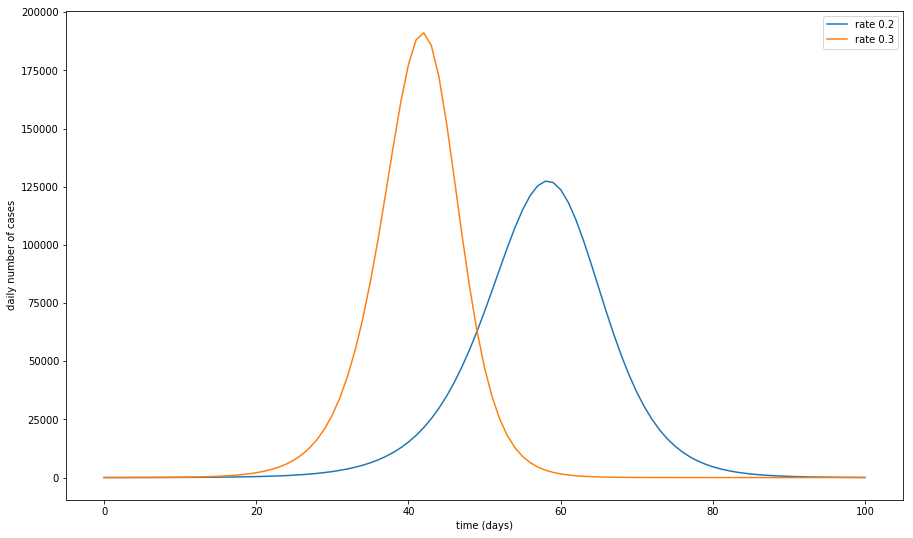

In [31]:
plt.figure(figsize=(15,9))
plt.plot(y_ode,label='rate 0.2')
plt.plot(y_ode2,label='rate 0.3')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

By enacting stay-at-home policices, we can also reduce the total population infected down the road, which also would affect the curve over time.


This would also lower the peak of infection.

In [32]:
y_ode3 = []
y_ode3.append(np.exp(y_ca[0]))
pop3=2550000# Number of new yorkers to be infected according to DeBlasio
c3=0.3
y_ode4 = []
y_ode4.append(np.exp(y_ca[0]))
pop4=1550000# Number of new yorkers to be infected according to DeBlasio
c4=0.3

In [33]:
for i in range(100):
    if len(y_ode3)==1:
        sum_ode3=0.5*y_ode3[-1]
        sum_ode4=0.5*y_ode4[-1]
    elif len(y_ode3)==2:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])
    else:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])+sum(y_ode3[1:-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])+sum(y_ode4[1:-1])
    y_temp3 = c3*y_ode3[-1]*(pop3-sum_ode3-sum_ode3)/pop3+y_ode3[-1]
    y_ode3.append(y_temp3)
    y_temp4 = c4*y_ode4[-1]*(pop4-sum_ode4-sum_ode4)/pop4+y_ode4[-1]
    y_ode4.append(y_temp4)

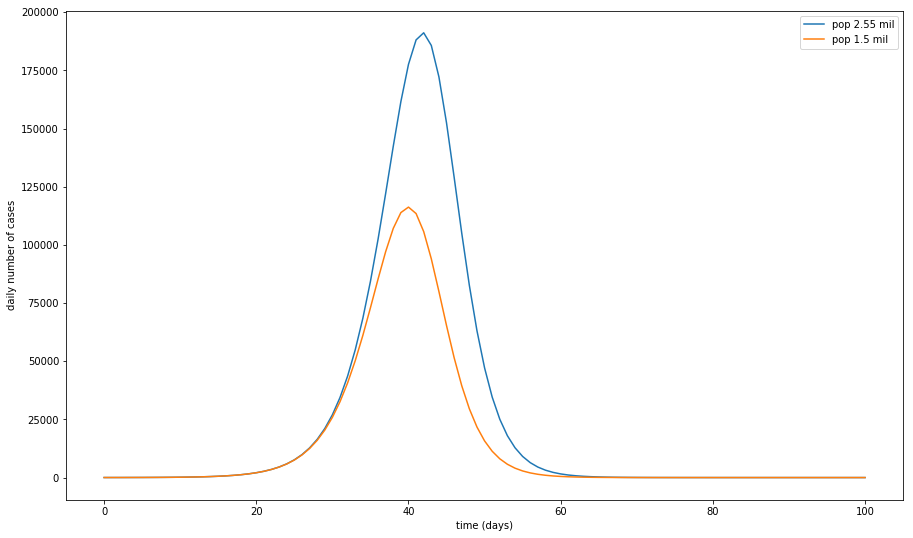

In [34]:
plt.figure(figsize=(15,9))
plt.plot(y_ode3,label='pop 2.55 mil')
plt.plot(y_ode4,label='pop 1.5 mil')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

Government efforts could also reduce infection rate and the overall infected population.

In [35]:
y_ode3 = []
y_ode3.append(np.exp(y_ca[0]))
pop3=2550000# Number of new yorkers to be infected according to DeBlasio
c3=0.3
y_ode4 = []
y_ode4.append(np.exp(y_ca[0]))
pop4=1550000# Number of new yorkers to be infected according to DeBlasio
c4=0.2

In [36]:
for i in range(100):
    if len(y_ode3)==1:
        sum_ode3=0.5*y_ode3[-1]
        sum_ode4=0.5*y_ode4[-1]
    elif len(y_ode3)==2:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])
    else:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])+sum(y_ode3[1:-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])+sum(y_ode4[1:-1])
    y_temp3 = c3*y_ode3[-1]*(pop3-sum_ode3-sum_ode3)/pop3+y_ode3[-1]
    y_ode3.append(y_temp3)
    y_temp4 = c4*y_ode4[-1]*(pop4-sum_ode4-sum_ode4)/pop4+y_ode4[-1]
    y_ode4.append(y_temp4)

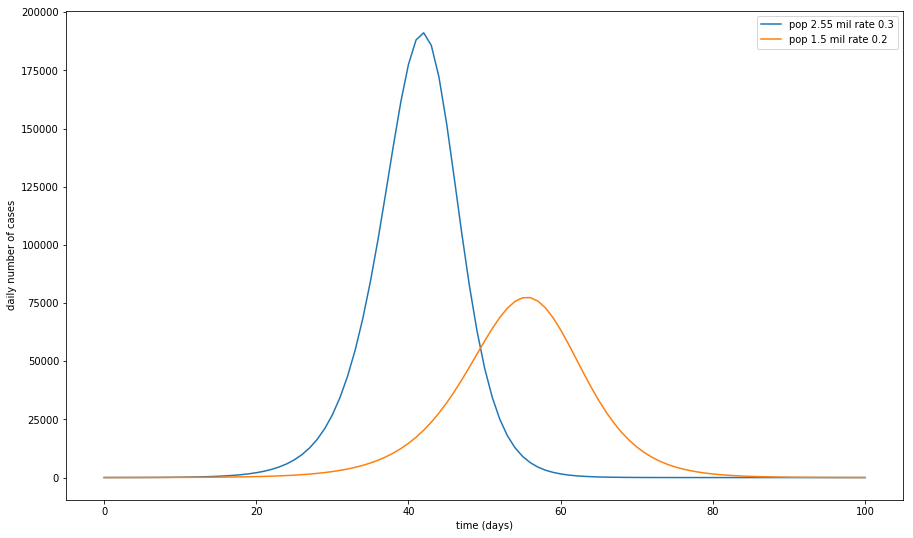

In [37]:
plt.figure(figsize=(15,9))
plt.plot(y_ode3,label='pop 2.55 mil rate 0.3')
plt.plot(y_ode4,label='pop 1.5 mil rate 0.2')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()